In [1]:
import torch

import os

from data.dataset import WheatHeadsDataset

t = WheatHeadsDataset('./data/gwhd_2021/', 'all', download=False)

/home/js/miniconda3/envs/masters-pt/lib/python3.10/site-packages/neptune/internal/backends/hosted_client.py:48: NeptuneDeprecationWarning: The 'neptune-client' package has been deprecated and will be removed in the future. Install the 'neptune' package instead. For more, see https://docs.neptune.ai/setup/upgrading/
  from neptune.version import version as neptune_client_version
/home/js/miniconda3/envs/masters-pt/lib/python3.10/site-packages/pytorch_lightning/loggers/neptune.py:39: NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
  from neptune import new as neptune


[[99, 692, 160, 764], [641, 27, 697, 115], [935, 978, 1012, 1020], [377, 834, 463, 890], [654, 797, 696, 837], [241, 768, 310, 861], [230, 911, 335, 965], [321, 753, 420, 825], [652, 522, 741, 566], [0, 14, 91, 73], [782, 55, 880, 111], [808, 714, 841, 775], [0, 915, 66, 949], [914, 219, 989, 273], [778, 449, 852, 512], [350, 911, 398, 960], [104, 840, 164, 879], [787, 848, 870, 905], [804, 425, 854, 482], [201, 141, 303, 195], [599, 378, 710, 425], [658, 31, 735, 92], [840, 981, 934, 1016], [0, 493, 61, 532], [512, 412, 572, 447], [686, 399, 760, 453], [922, 348, 950, 428], [495, 92, 580, 147], [439, 285, 497, 330], [0, 272, 59, 322], [701, 916, 743, 962], [67, 228, 154, 287], [140, 449, 207, 483], [774, 512, 842, 545], [610, 212, 692, 293], [770, 857, 840, 904], [514, 920, 581, 976], [728, 43, 826, 133], [274, 8, 363, 57], [718, 245, 812, 299], [409, 0, 548, 42]]


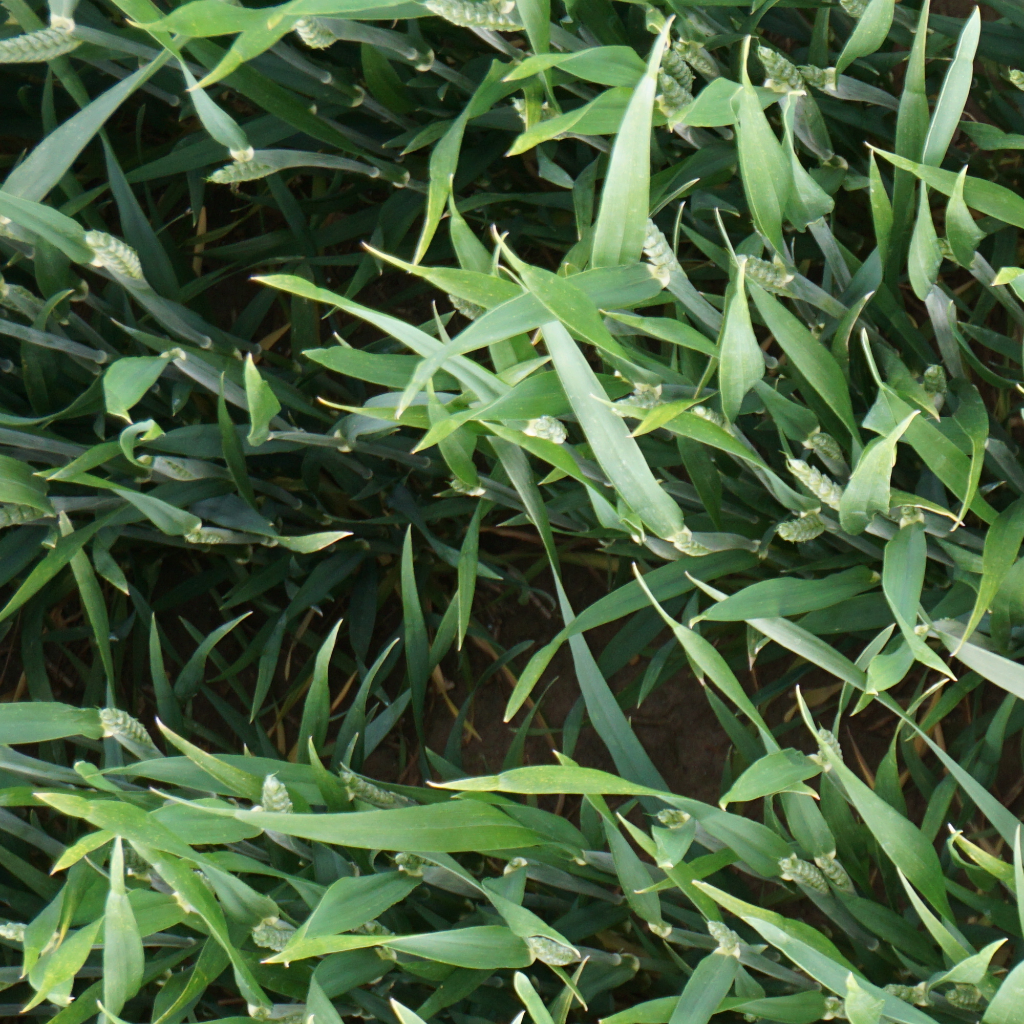

In [3]:
print(t._load_target(0, 'bboxes'))
t._load_image(0)

In [4]:
from data.dataset import WheatHeadsDataModule

m = WheatHeadsDataModule('./data/gwhd_2021', 8, None, None)

In [1]:
from easyimages import EasyImageList
l = EasyImageList.from_folder('./data/gwhd_2021/images/')
l.html(sample=40)

,image_name,BoxesString,domain
0,255b6ca9fea63f44125e5174bc932470b604c760430715...,481 820 604 922;655 957 732 1024;930 926 1013 ...,UQ_7
1,7f5eb37cab658de6fd0d688bf27f16e423794fed6184d8...,896 911 977 955;800 898 821 941;770 867 804 90...,UQ_7
2,7bcfff43b356f4a94948367782aa704a37ff4579baf45d...,892 993 922 1024;844 943 871 965;758 926 801 9...,UQ_7
3,e535384eda9d0f9c6ac57dd9397d5d614e4cad48c144d8...,648 886 722 1024;392 950 507 1024;876 677 981 ...,UQ_7
4,66e9fa7379fd7b7fd64024ac1b03b8e56f9ad020c10635...,559 939 623 1009;775 875 829 919;853 883 888 9...,UQ_7
...,...,...,...
1377,36064fc36d5d54025c3bafcb0e061cc81347389cc85927...,88 315 166 477;242 506 288 641;131 622 180 752...,ARC_1
1378,92e363996758d6261726abf33f7555b4f1503306b19887...,179 420 230 497;65 379 134 422;114 281 173 358...,ARC_1
1379,982dfbbc5b5eca9017fe407b9befdd3e709600ce9ae446...,81 161 182 302;235 199 365 289;0 290 111 413;4...,ARC_1
1380,385345ab4b25350b8f2fc7ab86b258271dd35b5558b4ab...,539 636 774 711;439 732 599 865;635 847 892 94...,ARC_1
